## Sparse Matrix Example

This notebook implements a SENSE Example with sparse interpolation matrices. A primary slowing effect of the NUFFT operation is out-of-order memory look-ups. The benefit of using sparse matrices is that the best order for writing the off-grid data is encoded into the sparse matrix, which can lead to much faster NUFFT operations. Prior to v0.2.0 of TorchKbNufft, this led to dramatic speed-ups over normal operation modes.

### Note

This notebook uses the shepp_logan_phantom from scikit-image, which is included in scikit-image v0.16. The standard Anaconda scikit-image as of this writing is 0.15. To use this notebook, you'll need to upgrade scikit-image to v0.16, e.g. ```conda install -c conda-forge scikit-image=0.16```.

### Note

PyTorch implemented a large number of improvements to the sparse matrix implementation in PyTorch 1.2. Results from this notebook can vary drastically depending on your version of PyTorch.

In [1]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from torchkbnufft import MriSenseNufft, AdjMriSenseNufft, KbNufft, AdjKbNufft
from torchkbnufft.mri.dcomp_calc import calculate_radial_dcomp_pytorch
from torchkbnufft.mri.mrisensesim import mrisensesim
from torchkbnufft.math import absolute
from torchkbnufft.nufft.sparse_interp_mat import precomp_sparse_mats

dtype = torch.float

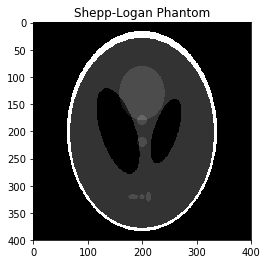

In [2]:
# create a simple shepp logan phantom and plot it
image = shepp_logan_phantom().astype(np.complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.title('Shepp-Logan Phantom')
plt.show()

In [3]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image = np.stack((np.real(image), np.imag(image)))
image = torch.tensor(image).to(dtype).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image.shape))

image shape: torch.Size([1, 1, 2, 400, 400])


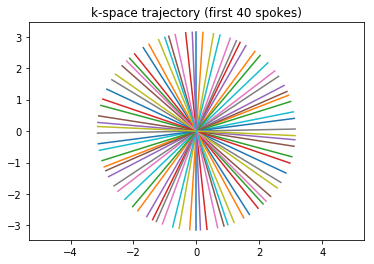

In [4]:
# create a k-space trajectory and plot it
spokelength = image.shape[-1] * 2
grid_size = (spokelength, spokelength)
nspokes = 405

ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the first 40 spokes
plt.plot(kx[:40, :].transpose(), ky[:40, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory (first 40 spokes)')
plt.show()

In [5]:
# convert k-space trajectory to a tensor and unsqueeze batch dimension
ktraj = torch.tensor(ktraj).to(dtype).unsqueeze(0)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([1, 2, 324000])


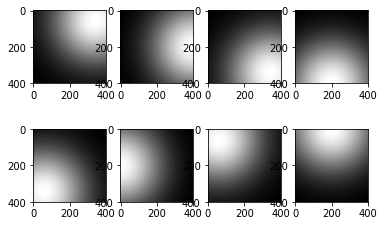

In [6]:
# simulate some sensitivity coils (no phase for simplicity)
ncoil = 8
smap = np.absolute(np.stack(mrisensesim(im_size, coil_width=64))).astype(np.complex)

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    ax.imshow(np.absolute(smap[i]))
plt.gray()
    
plt.show()

In [7]:
# convert smaps to tensors, unsqueeze batch dimension
smap = np.stack((np.real(smap), np.imag(smap)), axis=1)
smap = torch.tensor(smap).to(dtype).unsqueeze(0)

In [8]:
# build sense-nufft operators
sensenufft_ob = MriSenseNufft(smap=smap, im_size=im_size, grid_size=grid_size).to(dtype)
adjsensenufft_ob = AdjMriSenseNufft(smap=smap, im_size=im_size, grid_size=grid_size).to(dtype)
nufft_ob = KbNufft(im_size=im_size, grid_size=grid_size, norm='ortho').to(dtype)
adjnufft_ob = AdjKbNufft(im_size=im_size, grid_size=grid_size, norm='ortho').to(dtype)

In [9]:
# precompute the sparse interpolation matrices
real_mat, imag_mat = precomp_sparse_mats(ktraj, adjnufft_ob)
interp_mats = {
    'real_interp_mats': real_mat,
    'imag_interp_mats': imag_mat
}

In [10]:
# calculate k-space data, run some time tests
start_normal = time.perf_counter()
kdata = sensenufft_ob(image, ktraj)
end_normal = time.perf_counter()

start_spmat = time.perf_counter()
kdata = sensenufft_ob(image, ktraj, interp_mats)
end_spmat = time.perf_counter()

# add some noise (robustness test)
siglevel = absolute(kdata, dim=2).mean()
kdata = kdata + (siglevel/5) * torch.randn(kdata.shape)

# write the timings
# for forward problem, sparse matrices often don't help
print('normal interpolation time: {}'.format(end_normal-start_normal))
print('sparse matrix interpolation time: {}'.format(end_spmat-start_spmat))

normal interpolation time: 1.7195366509840824
sparse matrix interpolation time: 1.6822205049684271


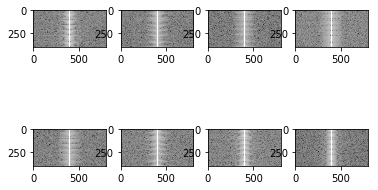

In [11]:
# convert kdata to numpy and plot
kdata_numpy = np.reshape(kdata.numpy(), (ncoil, 2, nspokes, spokelength))
kdata_numpy = kdata_numpy[:, 0] + 1j*kdata_numpy[:, 1]

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    ax.imshow(np.log10(np.absolute(kdata_numpy[i])))
plt.gray()
    
plt.show()

In [12]:
# adjnufft back
# method 1: no density compensation (blurry image)
# run timing tests here
start_normal = time.perf_counter()
image_blurry = adjsensenufft_ob(kdata, ktraj)
end_normal = time.perf_counter()

start_spmat = time.perf_counter()
image_blurry = adjsensenufft_ob(kdata, ktraj, interp_mats)
end_spmat = time.perf_counter()

# print the timings
# usually sparse matrices help here
print('normal interpolation time: {}'.format(end_normal-start_normal))
print('sparse matrix interpolation time: {}'.format(end_spmat-start_spmat))

# method 2: use density compensation
dcomp = calculate_radial_dcomp_pytorch(nufft_ob, adjnufft_ob, ktraj).unsqueeze(0).unsqueeze(0)
image_sharp = adjsensenufft_ob(kdata * dcomp, ktraj)

normal interpolation time: 2.7728744560154155
sparse matrix interpolation time: 1.3782810400007293


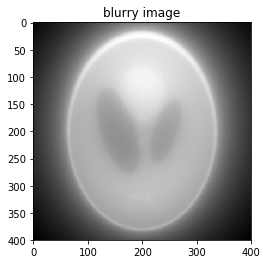

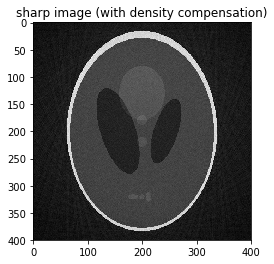

In [13]:
# show the images, some phase errors may occur due to smap
image_blurry_numpy = np.squeeze(image_blurry.numpy())
image_blurry_numpy = image_blurry_numpy[0] + 1j*image_blurry_numpy[1]

image_sharp_numpy = np.squeeze(image_sharp.numpy())
image_sharp_numpy = image_sharp_numpy[0] + 1j*image_sharp_numpy[1]

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy))
plt.gray()
plt.title('blurry image')

plt.figure(1)
plt.imshow(np.absolute(image_sharp_numpy))
plt.gray()
plt.title('sharp image (with density compensation)')

plt.show()